In [1]:
# Importowanie niezbędnych bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.utils import resample
from scipy import stats 

# Wczytywanie zbioru danych
df = pd.read_csv('dengue.csv', compression='gzip')

# Sprawdzenie dostępnych kolumn
print("Dostępne kolumny w zbiorze danych:", df.columns)

Dostępne kolumny w zbiorze danych: Index(['serial', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'conditions', 'stations', 'cases', 'labels'],
      dtype='object')


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   serial            602 non-null    int64  
 1   tempmax           602 non-null    float64
 2   tempmin           602 non-null    float64
 3   temp              602 non-null    float64
 4   feelslikemax      602 non-null    float64
 5   feelslikemin      602 non-null    float64
 6   feelslike         602 non-null    float64
 7   dew               602 non-null    float64
 8   humidity          602 non-null    float64
 9   precip            602 non-null    float64
 10  precipprob        602 non-null    float64
 11  precipcover       602 non-null    float64
 12  snow              602 non-null    float64
 13  snowdepth         602 non-null    float64
 14  windspeed         602 non-null    float64
 15  winddir           602 non-null    float64
 16  sealevelpressure  602 non-null    float64
 1

### Analiza korelacji i wybór cech

In [3]:
corr_matrix = df[['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'cases']].corr()
print(corr_matrix['cases'].sort_values(ascending=False))

cases           1.000000
feelslike       0.415344
temp            0.378149
feelslikemin    0.376015
tempmin         0.364691
feelslikemax    0.304087
tempmax         0.284181
Name: cases, dtype: float64


### Wybór cechy najlepiej skorelowanej ze zmienną docelową


In [4]:
best_temp_feature = corr_matrix['cases'].drop('cases').idxmax()
print(f"Najlepiej skorelowana cecha temperaturowa: {best_temp_feature}")

Najlepiej skorelowana cecha temperaturowa: feelslike


### Wybór cech do analizy (w tym najlepiej skorelowana cecha)

In [5]:
features = [best_temp_feature, 'humidity', 'precip', 'windspeed', 'solarradiation']

### Dodanie nowej cechy, np. heat_index (może być obliczana jako średnia temp i humidity)

In [6]:
df['heat_index'] = (df[best_temp_feature] + df['humidity']) / 2  # Przykład stworzenia nowej cechy

1. Regresja

Mean Squared Error (MSE) dla regresji: 31269051.35000147


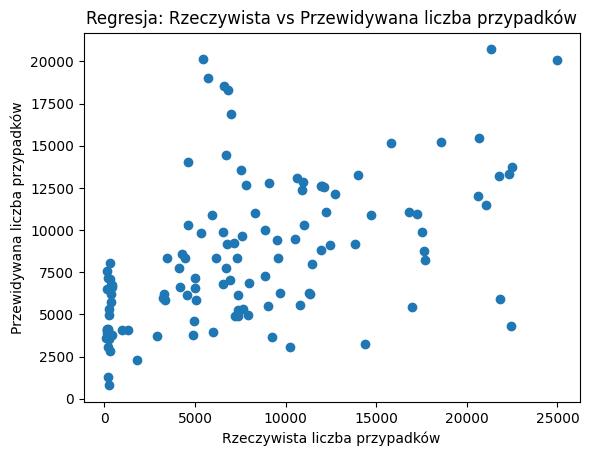

In [7]:
# Dla regresji: Przewidywanie liczby przypadków
X_reg = df[features + ['heat_index']]  # Wybór cech
y_reg = df['cases']   # Zmienna docelowa do regresji

# Podział na zbiory treningowy i testowy
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Skalowanie cech
scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)

# Budowanie modelu regresji
model_reg = LinearRegression()
model_reg.fit(X_train_reg, y_train_reg)

# Przewidywanie na zbiorze testowym
y_pred_reg = model_reg.predict(X_test_reg)

# Ocena modelu regresji
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f'Mean Squared Error (MSE) dla regresji: {mse}')

# Wizualizacja wyników regresji
plt.scatter(y_test_reg, y_pred_reg)
plt.xlabel('Rzeczywista liczba przypadków')
plt.ylabel('Przewidywana liczba przypadków')
plt.title('Regresja: Rzeczywista vs Przewidywana liczba przypadków')
plt.show()


2. Klasyfikacja

In [8]:
# Kategoryzowanie liczby przypadków (przykład)
bins = [0, 10, 50, 100, np.inf]  # dostosuj kategorie do swojego zbioru danych
labels = ['Niska', 'Średnia', 'Wysoka', 'Bardzo Wysoka']
df['severity'] = pd.cut(df['cases'], bins=bins, labels=labels)


# Sprawdzenie dystrybucji klas przed nadpróbkowaniem
print("Dystrybucja klas przed nadpróbkowaniem:")
print(df['severity'].value_counts())

# Sprawdzenie, czy klasa 'Niska' istnieje i jej nadpróbkowanie
if 'Niska' in df['severity'].values:
    df_minority = df[df['severity'] == 'Niska']
    df_majority = df[df['severity'] != 'Niska']

    # Nadpróbkowanie klasy mniejszościowej
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
else:
    print("Brak danych dla klasy 'Niska', pomijam nadpróbkowanie.")
    df_upsampled = df



# Wybór cech do klasyfikacji
X_clf = df_upsampled[features + ['heat_index']]
y_clf = df_upsampled['severity']

# Podział na zbiory treningowy i testowy
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Skalowanie cech
X_train_clf = scaler.fit_transform(X_train_clf)
X_test_clf = scaler.transform(X_test_clf)

# Budowanie modelu klasyfikacji
model_clf = RandomForestClassifier(random_state=42)
model_clf.fit(X_train_clf, y_train_clf)

# Przewidywanie na zbiorze testowym
y_pred_clf = model_clf.predict(X_test_clf)

# Ocena modelu klasyfikacji
print(classification_report(y_test_clf, y_pred_clf))



Dystrybucja klas przed nadpróbkowaniem:
severity
Bardzo Wysoka    582
Wysoka            20
Niska              0
Średnia            0
Name: count, dtype: int64
Brak danych dla klasy 'Niska', pomijam nadpróbkowanie.
               precision    recall  f1-score   support

Bardzo Wysoka       0.99      1.00      1.00       120
       Wysoka       0.00      0.00      0.00         1

     accuracy                           0.99       121
    macro avg       0.50      0.50      0.50       121
 weighted avg       0.98      0.99      0.99       121



c:\Users\Dawid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dawid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dawid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Wizualizacja macierzy pomyłek

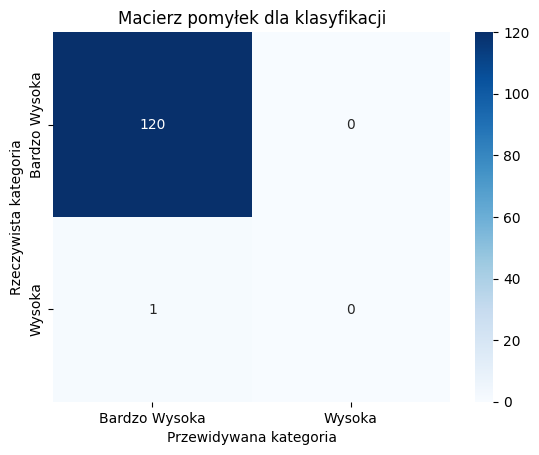

In [9]:

cm = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_clf.classes_, yticklabels=model_clf.classes_)
plt.xlabel('Przewidywana kategoria')
plt.ylabel('Rzeczywista kategoria')
plt.title('Macierz pomyłek dla klasyfikacji')
plt.show()

# Eksploracja i wstępne przetwarzanie danych:

### Usunięcie kolumny 'serial'

In [10]:
df = df.drop(columns=['serial'])
df.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,visibility,solarradiation,solarenergy,uvindex,conditions,stations,cases,labels,heat_index,severity
0,34.053151,24.478082,28.709863,39.757808,25.317808,32.306301,22.971233,73.508219,2.921726,44.657534,...,3.789863,208.097808,17.973699,7.232877,2.558904,1.197260,4925.0,normal,52.907260,Bardzo Wysoka
1,34.086179,25.694309,29.464228,41.338211,28.140650,34.423577,23.484553,72.066667,3.783415,39.837398,...,2.884553,222.926016,19.246341,7.504065,1.658537,0.991870,5077.0,normal,53.245122,Bardzo Wysoka
2,34.573984,25.417886,29.526829,40.464228,26.560163,33.085366,22.580488,69.424390,3.065854,33.333333,...,4.242276,229.413008,19.802439,7.829268,1.910569,1.170732,7579.0,normal,51.254878,Bardzo Wysoka
3,33.020325,25.080488,28.727642,37.878049,26.193496,31.772358,21.752033,69.297561,6.025203,37.398374,...,2.991057,225.421951,19.480488,7.593496,1.300813,0.146341,13706.0,normal,50.534959,Bardzo Wysoka
4,30.660976,24.230894,26.774797,36.586992,24.263415,28.943902,24.214634,86.652033,23.336585,96.747967,...,3.886992,176.598374,15.261789,6.186992,0.967480,3.951220,82.0,normal,57.797967,Wysoka


### Zaokrąglanie wartości w początkowych rekordach

In [11]:
df.iloc[:15] = df.iloc[:15].round(2)

### Usunięcie kolumn nieinformacyjnych

In [12]:
df = df.drop(columns=['snow', 'labels'])
df.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,stations,cases,heat_index,severity
0,34.05,24.48,28.71,39.76,25.32,32.31,22.97,73.51,2.92,44.66,...,50.75,3.79,208.10,17.97,7.23,2.56,1.20,4925.0,52.91,Bardzo Wysoka
1,34.09,25.69,29.46,41.34,28.14,34.42,23.48,72.07,3.78,39.84,...,48.31,2.88,222.93,19.25,7.50,1.66,0.99,5077.0,53.25,Bardzo Wysoka
2,34.57,25.42,29.53,40.46,26.56,33.09,22.58,69.42,3.07,33.33,...,55.62,4.24,229.41,19.80,7.83,1.91,1.17,7579.0,51.25,Bardzo Wysoka
3,33.02,25.08,28.73,37.88,26.19,31.77,21.75,69.30,6.03,37.40,...,50.21,2.99,225.42,19.48,7.59,1.30,0.15,13706.0,50.53,Bardzo Wysoka
4,30.66,24.23,26.77,36.59,24.26,28.94,24.21,86.65,23.34,96.75,...,45.54,3.89,176.60,15.26,6.19,0.97,3.95,82.0,57.80,Wysoka


# Wizualizacja rozkładów cech

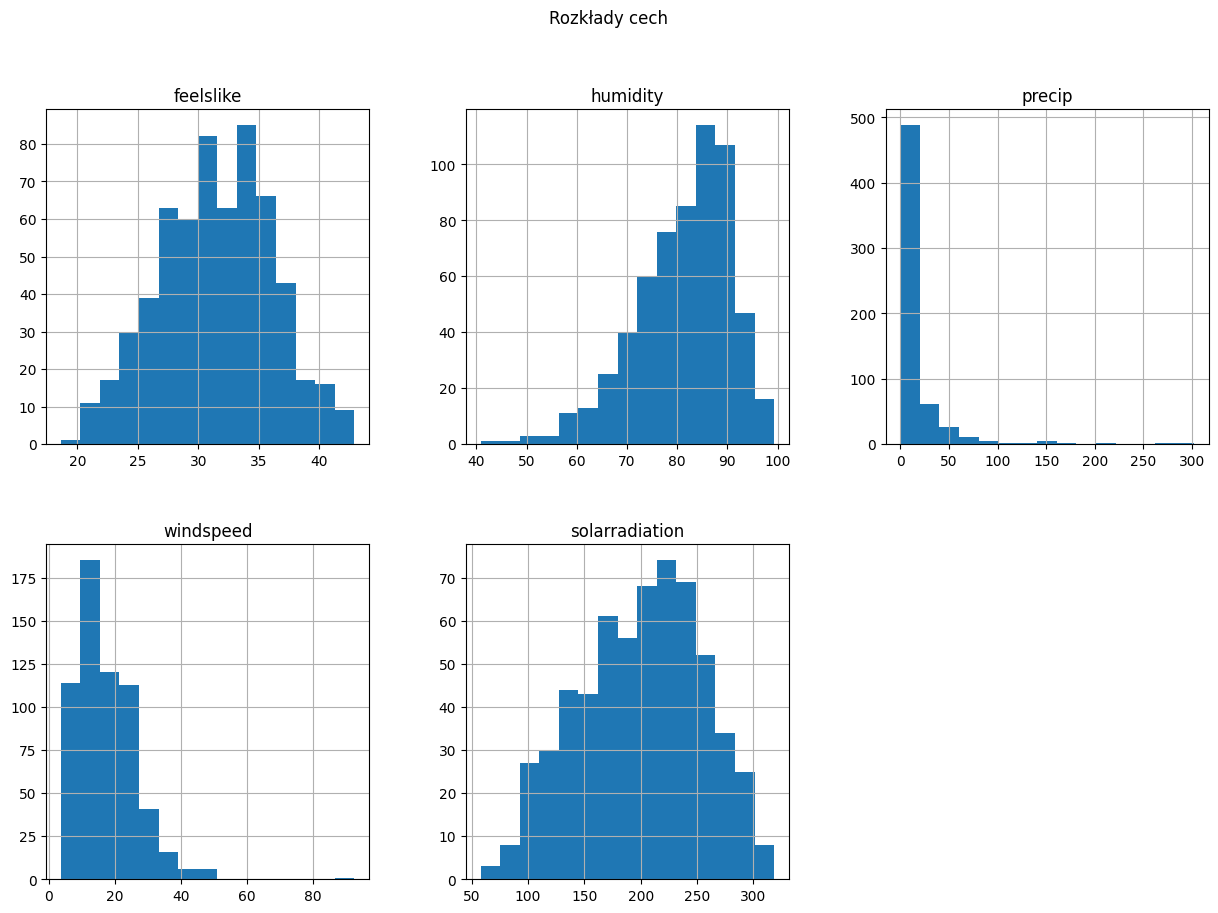

In [13]:
df[features].hist(bins=15, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Rozkłady cech')
plt.show()

# Wykresy pudełkowe (Box plots) dla cech

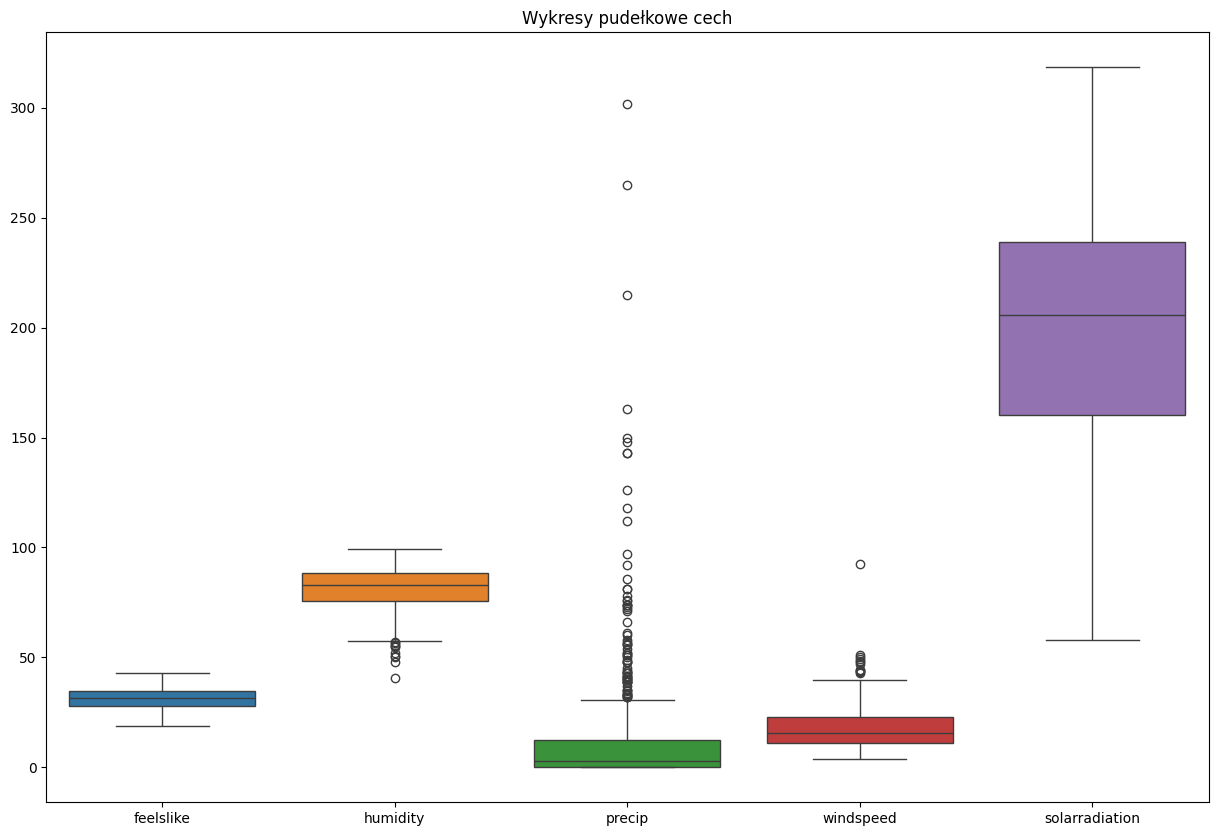

In [14]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[features])
plt.title('Wykresy pudełkowe cech')
plt.show()

# Macierz korelacji

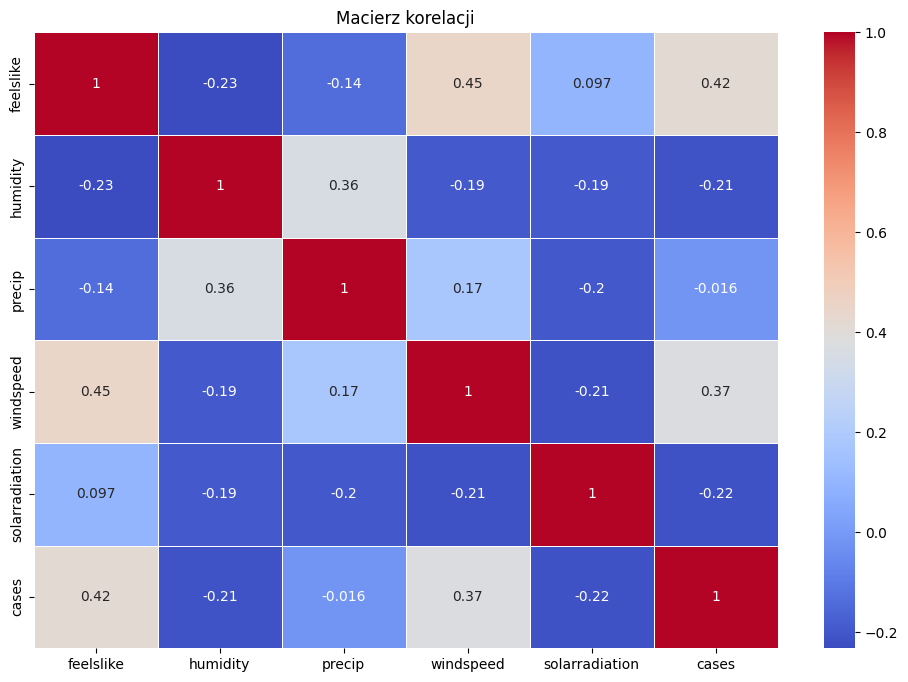

In [15]:
plt.figure(figsize=(12, 8))
correlation_matrix = df[features + ['cases']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Macierz korelacji')
plt.show()


# Relacja między cechami a zmienną docelową (liczba przypadków)

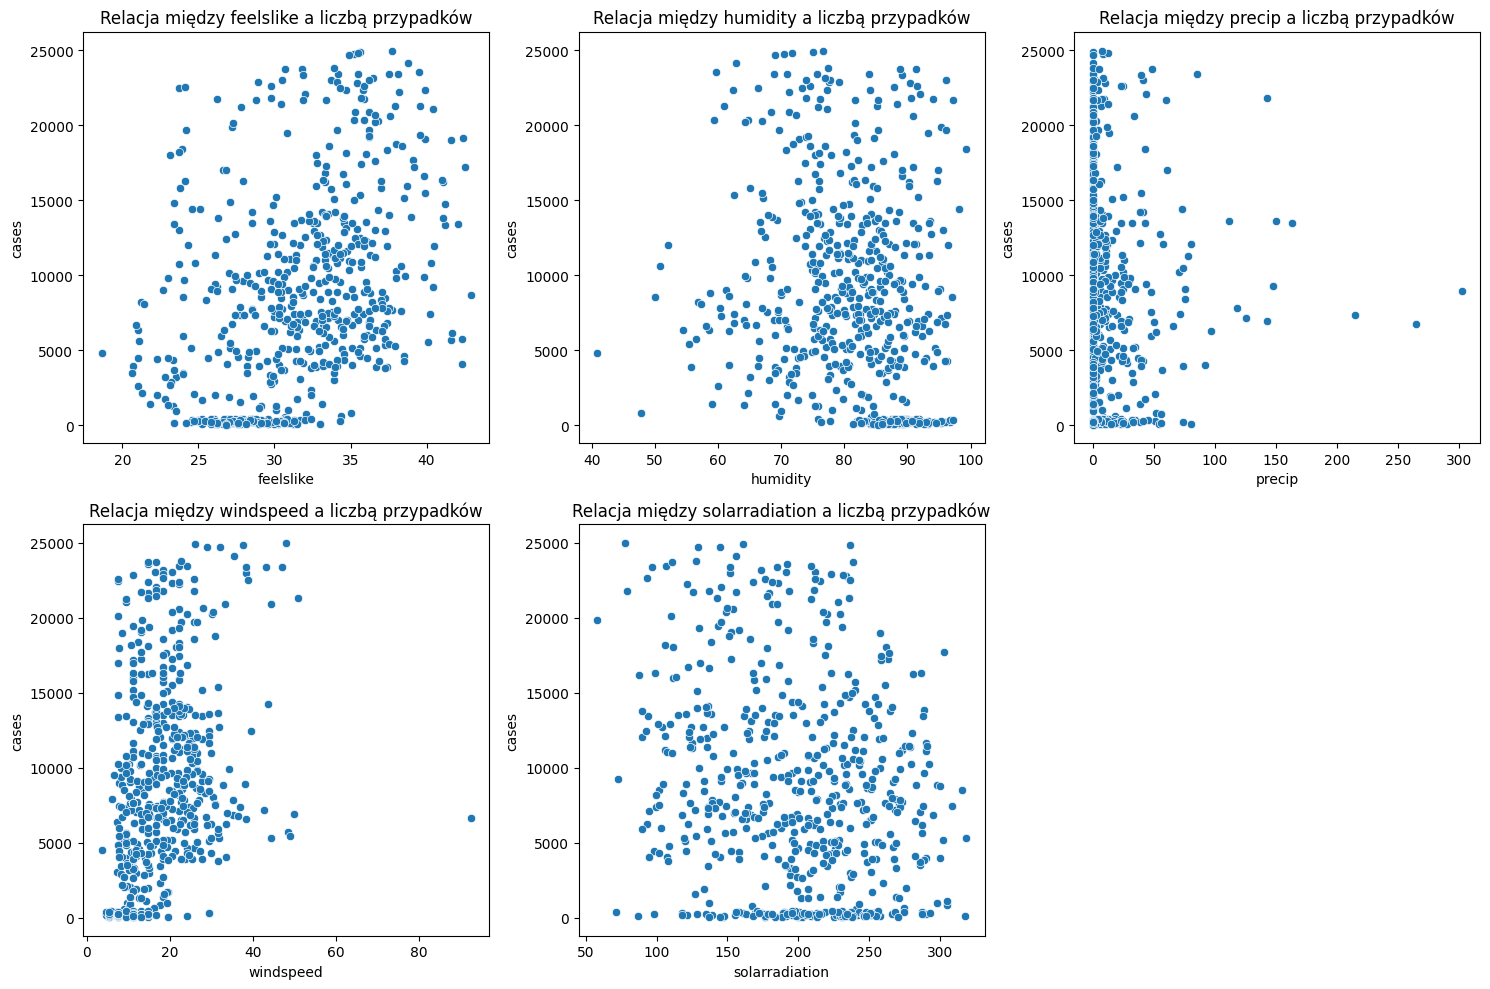

In [16]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=df[feature], y=df['cases'])
    plt.title(f'Relacja między {feature} a liczbą przypadków')
plt.tight_layout()
plt.show()

# Identyfikacja wartości odstających (outliers) dla 'cases'

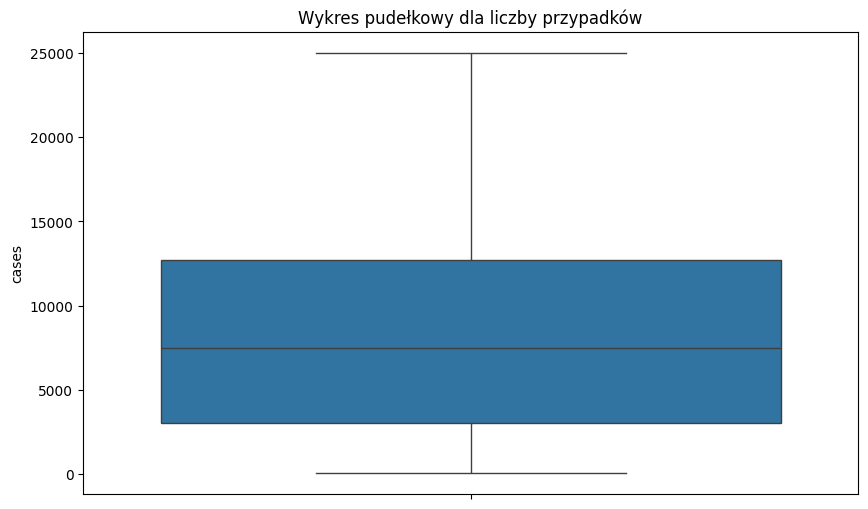

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(df['cases'])
plt.title('Wykres pudełkowy dla liczby przypadków')
plt.show()

### Weryfikacja anomalii i radzenie sobie z błędnymi wartościami
> Przykład: Sprawdzanie anomalii w kolumnie 'sealevelpressure'

In [18]:
if 'sealevelpressure' in df.columns:
    print("Liczba wierszy z 'sealevelpressure' równym 0:", (df['sealevelpressure'] == 0).sum())
    
    # Zakładamy, że 0 oznacza brak danych - w takim przypadku imputujemy medianę
    df['sealevelpressure'].replace(0, np.nan, inplace=True)
    df['sealevelpressure'].fillna(df['sealevelpressure'].median(), inplace=True)

Liczba wierszy z 'sealevelpressure' równym 0: 1


C:\Users\Dawid\AppData\Local\Temp\ipykernel_19860\1676934129.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sealevelpressure'].replace(0, np.nan, inplace=True)
C:\Users\Dawid\AppData\Local\Temp\ipykernel_19860\1676934129.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



### Wykrywanie wartości odstających i ekstremalnych
> Przykład: Analiza zmiennych numerycznych, np. 'precip' (opady)

In [19]:
numeric_columns = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'humidity', 'precip', 'windspeed', 'solarradiation']

### Wykrywanie wartości odstających za pomocą Z-score

In [20]:
z_scores = np.abs(stats.zscore(df[numeric_columns]))
outliers = (z_scores > 3).sum(axis=1)

print("Liczba wierszy z wartościami odstającymi (Z-score > 3):", (outliers > 0).sum())


Liczba wierszy z wartościami odstającymi (Z-score > 3): 34


# Przykład strategii zarządzania wartościami odstającymi:
1. Przekształcenia logarytmiczne dla 'precip'

In [21]:
df['precip_log'] = np.log1p(df['precip'])
df['precip_log'] 

0      1.366092
1      1.564441
2      1.403643
3      1.950187
4      3.192121
         ...   
597    0.000000
598    0.000000
599    0.000000
600    0.000000
601    0.000000
Name: precip_log, Length: 602, dtype: float64

2. Binning dla 'windspeed'

In [22]:
df['windspeed_binned'] = pd.cut(df['windspeed'], bins=5, labels=False)
df['windspeed_binned']

0      0
1      0
2      0
3      0
4      0
      ..
597    0
598    0
599    0
600    0
601    0
Name: windspeed_binned, Length: 602, dtype: int64

3. Ograniczanie (capping) wartości odstających dla 'humidity'

In [23]:
q_low = df['humidity'].quantile(0.01)
q_high = df['humidity'].quantile(0.99)
df['humidity_capped'] = np.clip(df['humidity'], q_low, q_high)
df['humidity_capped'] 

0      73.51
1      72.07
2      69.42
3      69.30
4      86.65
       ...  
597    75.00
598    68.50
599    71.10
600    65.90
601    60.40
Name: humidity_capped, Length: 602, dtype: float64

### Wizualizacja wpływu przekształceń na wartości odstające

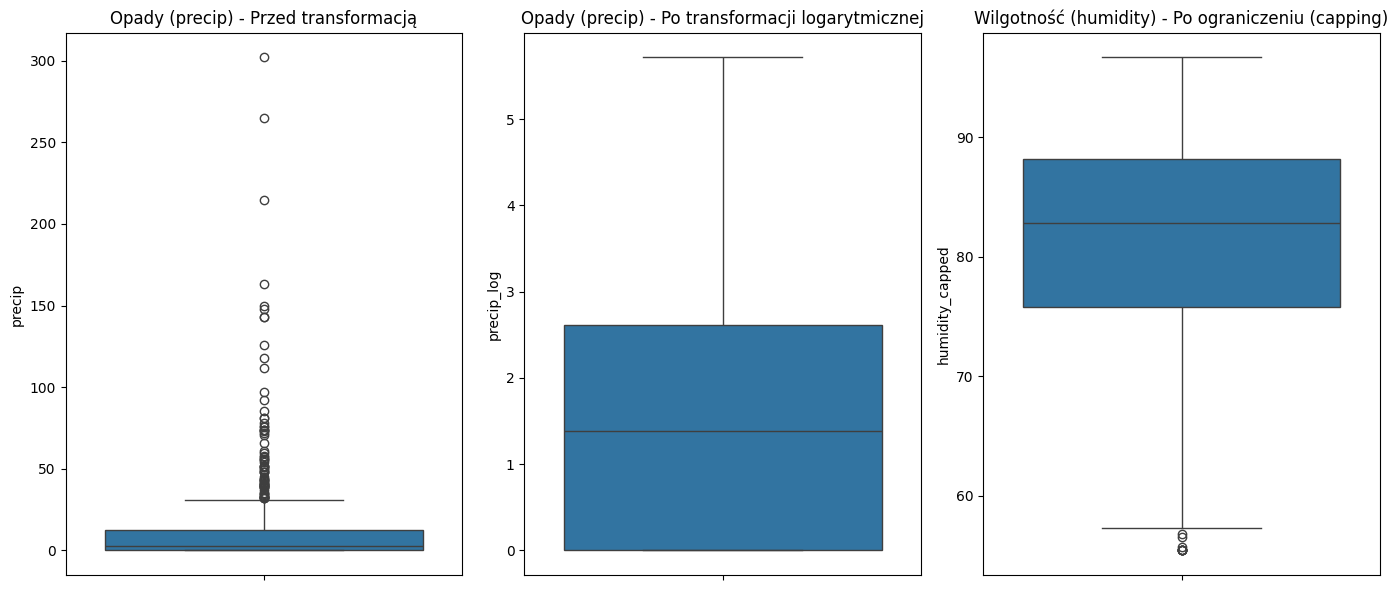

In [24]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['precip'])
plt.title('Opady (precip) - Przed transformacją')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['precip_log'])
plt.title('Opady (precip) - Po transformacji logarytmicznej')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['humidity_capped'])
plt.title('Wilgotność (humidity) - Po ograniczeniu (capping)')

plt.tight_layout()
plt.show()

# Rozwoj modelu

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler


# Wczytywanie zbioru danych
df = pd.read_csv('dengue.csv', compression='gzip')

# Sprawdzenie dostępnych kolumn
print(df.columns)


Index(['serial', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'conditions', 'stations', 'cases', 'labels'],
      dtype='object')


### Wybór kolumn do analizy

In [26]:
features = ['temp', 'humidity', 'precip', 'windspeed', 'solarradiation']
X = df[features]

### Przygotowanie zmiennej docelowej do regresji (zakładamy, że 'cases' jest zmienną do przewidywania)

In [27]:
y_reg = df['cases']

In [28]:
# Sprawdzenie, czy jest kolumna do klasyfikacji
# Użyj odpowiedniej kolumny dla klasyfikacji, np. 'labels' (jeśli to etykiety klas)
# y_class = df['labels'] 

# Podział na zbiory treningowy i testowy

In [29]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Skalowanie cech

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Regresja

1. Linear Regression


In [31]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train_reg)
y_pred_reg_lin = lin_reg.predict(X_test)
print("Linear Regression MSE:", mean_squared_error(y_test_reg, y_pred_reg_lin))

Linear Regression MSE: 33751804.674899116



2. Decision Tree Regressor

In [32]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train_reg)
y_pred_reg_tree = tree_reg.predict(X_test)
print("Decision Tree Regressor MSE:", mean_squared_error(y_test_reg, y_pred_reg_tree))

Decision Tree Regressor MSE: 52478899.97520661


3. Random Forest Regressor

In [33]:
random_forest_reg = RandomForestRegressor(random_state=42)
random_forest_reg.fit(X_train, y_train_reg)
y_pred_reg_rf = random_forest_reg.predict(X_test)
print("Random Forest Regressor MSE:", mean_squared_error(y_test_reg, y_pred_reg_rf))

Random Forest Regressor MSE: 29007256.634060327


4. Neural Network Regressor

In [42]:
model_nn_reg = Sequential()
model_nn_reg.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model_nn_reg.add(Dense(32, activation='relu'))
model_nn_reg.add(Dense(1))
model_nn_reg.compile(optimizer=Adam(), loss='mean_squared_error')

history_reg = model_nn_reg.fit(X_train, y_train_reg, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
y_pred_reg_nn = model_nn_reg.predict(X_test)
print("Neural Network Regressor MSE:", mean_squared_error(y_test_reg, y_pred_reg_nn))

Epoch 1/20


c:\Users\Dawid\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 120683640.0000 - val_loss: 133335960.0000
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126152832.0000 - val_loss: 133322176.0000
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114375912.0000 - val_loss: 133302792.0000
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114016968.0000 - val_loss: 133274840.0000
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118195512.0000 - val_loss: 133236008.0000
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112851040.0000 - val_loss: 133183296.0000
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126243400.0000 - val_loss: 133110808.0000
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114682904.0000 - val_loss: 133015448.0000
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121339648.0000 - val_loss: 132894760.0000
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118224240.0000 - val_loss: 132739800.0000
Epoch 11/2

# Klasyfikacja

In [36]:


# Klasyfikacja (jeśli masz kolumnę do klasyfikacji)
# X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)
# X_train_class = scaler.fit_transform(X_train_class)
# X_test_class = scaler.transform(X_test_class)

## Logistic Regression
# log_reg = LogisticRegression()
# log_reg.fit(X_train_class, y_train_class)
# y_pred_class_log = log_reg.predict(X_test_class)
# print("Logistic Regression Classification Report:")
# print(classification_report(y_test_class, y_pred_class_log))

## Decision Tree Classifier
# tree_clf = DecisionTreeClassifier(random_state=42)
# tree_clf.fit(X_train_class, y_train_class)
# y_pred_class_tree = tree_clf.predict(X_test_class)
# print("Decision Tree Classification Report:")
# print(classification_report(y_test_class, y_pred_class_tree))

## Random Forest Classifier
# random_forest_clf = RandomForestClassifier(random_state=42)
# random_forest_clf.fit(X_train_class, y_train_class)
# y_pred_class_rf = random_forest_clf.predict(X_test_class)
# print("Random Forest Classification Report:")
# print(classification_report(y_test_class, y_pred_class_rf))

## Neural Network Classifier
# model_nn = Sequential()
# model_nn.add(Dense(64, input_dim=X_train_class.shape[1], activation='relu'))
# model_nn.add(Dense(32, activation='relu'))
# model_nn.add(Dense(len(y_class.unique()), activation='softmax'))
# model_nn.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# history_class = model_nn.fit(X_train_class, y_train_class, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
# y_pred_class_nn = np.argmax(model_nn.predict(X_test_class), axis=-1)
# print("Neural Network Classification Report:")
# print(classification_report(y_test_class, y_pred_class_nn))

#   Walidacja Krzyżowa i Strojenie Hiperparametrów
## Przykład: Strojenie hiperparametrów dla Random Forest
# param_grid = {
#       'n_estimators': [50, 100, 200],
#      'max_depth': [10, 20, 30]
#}
#grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, verbose=1)
#grid_search.fit(X_train_class, y_train_class)
#print("Najlepsze parametry dla Random Forest:", grid_search.best_params_)
#print("Najlepszy wynik w walidacji krzyżowej:", grid_search.best_score_)


### Uzupełnienie o Metryki

In [37]:
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score

# RMSE dla regresji
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print(f'Root Mean Squared Error (RMSE) dla regresji: {rmse}')

# MAE dla regresji
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print(f'Mean Absolute Error (MAE) dla regresji: {mae}')

# Accuracy dla klasyfikacji
accuracy = accuracy_score(y_test_clf, y_pred_clf)
print(f'Accuracy dla klasyfikacji: {accuracy}')

# F1-score dla klasyfikacji
f1 = f1_score(y_test_clf, y_pred_clf, average='weighted')
print(f'F1-score dla klasyfikacji: {f1}')


Root Mean Squared Error (RMSE) dla regresji: 5591.87368866657
Mean Absolute Error (MAE) dla regresji: 4354.781106200103
Accuracy dla klasyfikacji: 0.9917355371900827
F1-score dla klasyfikacji: 0.9876204519735263


### Analiza Krzywych ROC i AUC

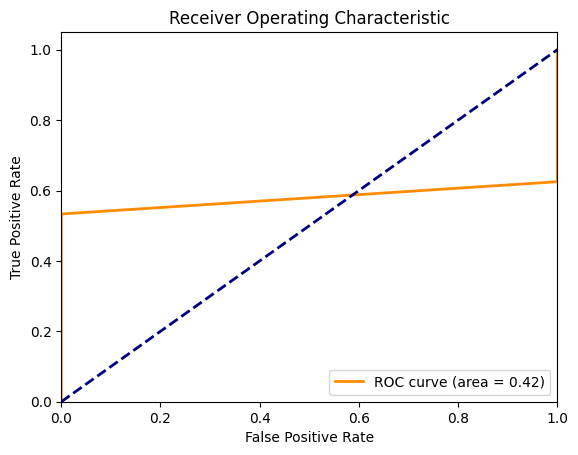

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score

# Krzywa ROC i AUC
fpr, tpr, _ = roc_curve(y_test_clf, model_clf.predict_proba(X_test_clf)[:, 1], pos_label='Bardzo Wysoka')
roc_auc = roc_auc_score(y_test_clf, model_clf.predict_proba(X_test_clf)[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Walidacja Krzyżowa

In [39]:
from sklearn.model_selection import cross_val_score

# Walidacja krzyżowa dla regresji
cv_scores_reg = cross_val_score(model_reg, X_reg, y_reg, cv=5, scoring='neg_mean_squared_error')
print(f'CV Mean Squared Error: {-np.mean(cv_scores_reg)}')

# Walidacja krzyżowa dla klasyfikacji
cv_scores_clf = cross_val_score(model_clf, X_clf, y_clf, cv=5, scoring='accuracy')
print(f'CV Accuracy: {np.mean(cv_scores_clf)}')

CV Mean Squared Error: 45964307.12446524
CV Accuracy: 0.9403305785123968


### Strojenie Hiperparametrów

In [40]:
from sklearn.model_selection import GridSearchCV

# Strojenie hiperparametrów dla Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30]
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_clf, y_train_clf)
print("Najlepsze parametry dla Random Forest:", grid_search.best_params_)
print("Najlepszy wynik w walidacji krzyżowej:", grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Najlepsze parametry dla Random Forest: {'max_depth': 10, 'n_estimators': 50}
Najlepszy wynik w walidacji krzyżowej: 0.956335910652921


### Porównanie Modeli

In [41]:
results = {
    'Model': ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'Neural Network Regressor'],
    'MSE': [mean_squared_error(y_test_reg, y_pred_reg_lin),
            mean_squared_error(y_test_reg, y_pred_reg_tree),
            mean_squared_error(y_test_reg, y_pred_reg_rf),
            mean_squared_error(y_test_reg, y_pred_reg_nn)],
    'RMSE': [np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_lin)),
             np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_tree)),
             np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_rf)),
             np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_nn))]
}

results_df = pd.DataFrame(results)
print(results_df)

                      Model           MSE          RMSE
0         Linear Regression  3.375180e+07   5809.630339
1   Decision Tree Regressor  5.247890e+07   7244.232187
2   Random Forest Regressor  2.900726e+07   5385.838527
3  Neural Network Regressor  1.000604e+08  10003.020053
